## Access Vessel SST Delayed QC data in Parquet

A jupyter notebook to show how to access and plot Vessel SST Delayed QC data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/67f0b6ea-518f-4af5-9d21-dd3c08c7cb5c).

In [1]:
dataset_name = "vessel_sst_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 54ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 117 ms, sys: 27.5 ms, total: 145 ms
Wall time: 6.88 s


In [5]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
polygon: string
platform_code: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('platform_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['HSB3402', 'HSB3403']
CPU times: user 11.3 ms, sys: 1.41 ms, total: 12.8 ms
Wall time: 11 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


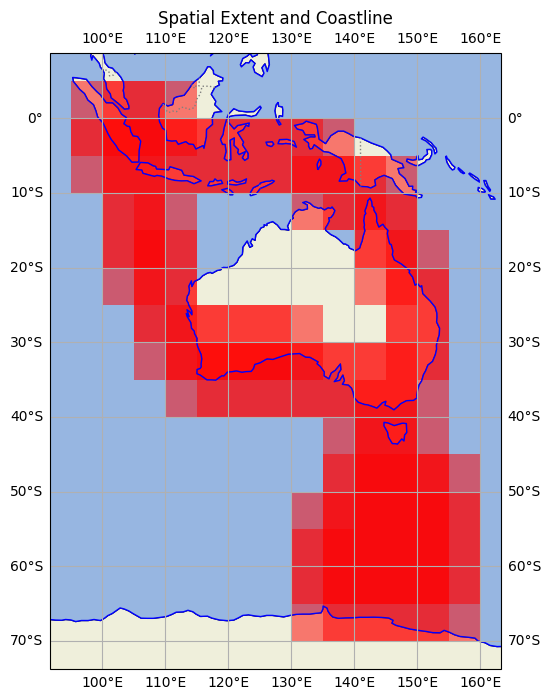

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2008-10-21 00:00:00'), Timestamp('2013-04-12 23:59:00.000003584'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:24:32,393 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/vessel_sst_delayed_qc.parquet
2025-06-05 13:24:32,629 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts of the day',
  'ancillary_variables': 'TIME_quality_control'},
 'LATITUDE': {'type': 'double',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'instrument': 'unknown',
  'observation_type': 'measured',
  'standard_name': 'latitude',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LATITUDE_quality_control'},
 'LONGITUDE': {'type': 'double',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'instrument': 'unknown',
  'observation_type': 'measured',
  'standard_name': 'longitude',
  'axis': 'X',
  'valid_min': -180,
  'valid_max': 180,
  'reference_datum': 'geographical coordinates, WGS84',
  'ancillary_variables': 'LONGITUDE_quality_control'},
 'TEMP': {'type': 'float',
  'long_name': 

In [10]:
metadata['global_attributes']['metadata_uuid']

'67f0b6ea-518f-4af5-9d21-dd3c08c7cb5c'

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2012-12-23 10:14:00', date_end='2013-04-01 07:50:00',lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262900 entries, 0 to 262899
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   TIME                       262900 non-null  datetime64[ns]
 1   LATITUDE                   262900 non-null  float64       
 2   LONGITUDE                  262900 non-null  float64       
 3   TEMP                       259220 non-null  float32       
 4   history                    262900 non-null  object        
 5   TIME_quality_control       262900 non-null  object        
 6   LATITUDE_quality_control   262900 non-null  object        
 7   LONGITUDE_quality_control  262900 non-null  object        
 8   TEMP_quality_control       262900 non-null  object        
 9   AIRT_quality_control       0 non-null       object        
 10  WSPD                       0 non-null       float32       
 11  WSPD_quality_control       0 non-null       object  

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

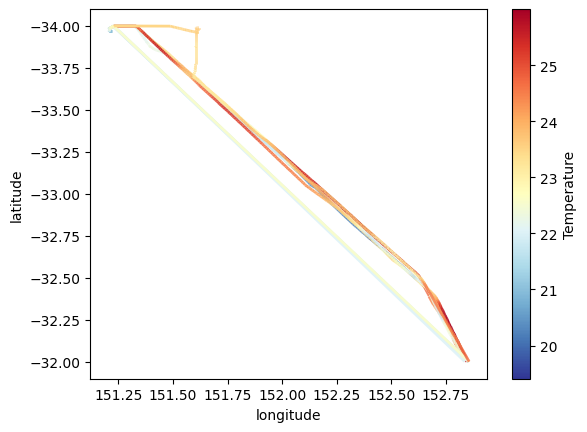

In [12]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()

## Create a TIME and scalar/number filter

In [13]:
%%time
df = aodn_dataset.get_data(date_start='2010-01-31 10:14:00', date_end='2010-02-01 07:50:00', scalar_filter={'platform_code': "FHZI"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   TIME                       25920 non-null  datetime64[ns]
 1   LATITUDE                   25920 non-null  float64       
 2   LONGITUDE                  25920 non-null  float64       
 3   TEMP                       25920 non-null  float32       
 4   history                    25920 non-null  object        
 5   TIME_quality_control       25920 non-null  object        
 6   LATITUDE_quality_control   25920 non-null  object        
 7   LONGITUDE_quality_control  25920 non-null  object        
 8   TEMP_quality_control       25920 non-null  object        
 9   AIRT_quality_control       25920 non-null  object        
 10  WSPD                       25920 non-null  float32       
 11  WSPD_quality_control       25920 non-null  object        
 12  WDIR

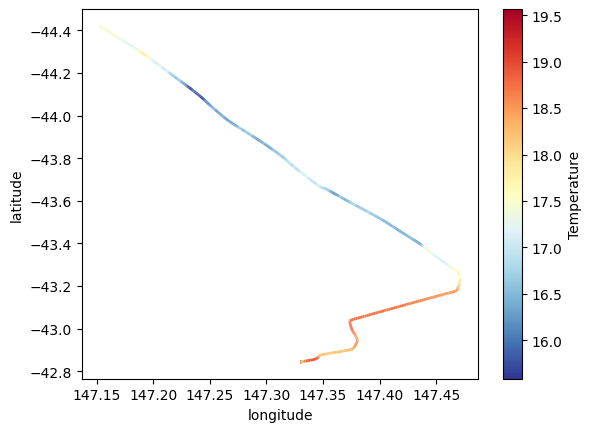

In [14]:
df_sorted = df.sort_values('TIME')

# Create a list of segments
points = np.array([df_sorted['LONGITUDE'], df_sorted['LATITUDE']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with segments colored by temperature
norm = plt.Normalize(df_sorted['TEMP'].min(), df_sorted['TEMP'].max())
lc = LineCollection(segments, cmap='RdYlBu_r', norm=norm)
lc.set_array(df_sorted['TEMP'])
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_xlabel(metadata['LONGITUDE']['standard_name'])
ax.set_ylabel(metadata['LATITUDE']['standard_name'])
ax.invert_yaxis()

# Adding color bar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Temperature')

plt.show()